## MLF - Mini Project 7: Predicting League of Legends Match Outcomes Using a Multi-Layer Perceptron (MLP)

Investigates how neural network complexity, including the number of layers, neurons, and learning parameters, influences the prediction of `blueWins` in League of Legends Diamond Ranked matches. Uses cross-validation and F1-macro to evaluate performance, visualize hyperparameter effects, and compare MLP models with simpler classifiers.

In [1]:
# General libraries
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns

# Visualization libraries
import matplotlib.pyplot as plt

# Statistical visualization
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score

# Keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from time import perf_counter

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')

## 1. Load and clean the League of Legends dataset
- Drop non-predictive IDs and leakage columns if present.
- Define features `X` and binary target `y = blueWins`.

In [2]:
# Load the dataset (note the use of the Path object)
df = pd.read_csv(Path("high_diamond_ranked_10min.csv"))

# Clean the dataset
df = df.dropna().drop_duplicates() # Remove missing values and duplicates

# Drop columns that are not useful for prediction
df = df.drop(columns=["gameId"], errors="ignore") # Drop 'gameId' if it exists
constant_cols = [c for c in df.columns if df[c].nunique() <= 1] # Identify constant columns
if constant_cols: 
    df = df.drop(columns=constant_cols) # Drop constant columns if any
    
# Features/target
y = df['blueWins'].astype(int).to_numpy()
X = df.drop(columns=['blueWins']).to_numpy()

## 2. CV search with `F1-macro`
Hyperparameters searched (≥3 as required):
- `hidden_layer_sizes` (mandatory)
- `alpha`
- `learning_rate_init`
- `activation`

Scoring uses **F1-macro** to weight both classes equally.

In [3]:
# Preprocessing and model pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', MLPClassifier(max_iter=200, solver='adam', random_state=42))
])

# Hyperparameter grid for tuning
param_grid = {
    'clf__hidden_layer_sizes': [(50,), (100,), (50, 10), (100, 10)], # Different architectures
    'clf__alpha': [1e-4, 1e-3, 1e-2], # Regularization strengths
    'clf__learning_rate_init': [1e-3, 1e-2, 1e-1], # Learning rates
    'clf__activation': ['relu', 'tanh', 'logistic'] # Activation functions
}

# Stratified K-Fold Cross-Validation with 3 folds
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Grid Search with F1-macro scoring
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    refit=True,
)

# Fit the grid search
grid.fit(X, y)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'clf__activation': ['relu', 'tanh', ...], 'clf__alpha': [0.0001, 0.001, ...], 'clf__hidden_layer_sizes': [(50,), (100,), ...], 'clf__learning_rate_init': [0.001, 0.01, ...]}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


## 3.A Table of tested hyperparameters and F1-macro
The table below lists all tested combinations with mean and std of **F1-macro** across 3 folds.

In [4]:
# Print best hyperparameters and corresponding score
print("Best Hyperparameters:", grid.best_params_)
print("Best F1-macro Score:", grid.best_score_)

# Extract and display cross-validation results
cvres = pd.DataFrame(grid.cv_results_)
cols = ['mean_test_score','std_test_score',
         'param_clf__hidden_layer_sizes',
         'param_clf__alpha',
         'param_clf__learning_rate_init']

# Show sorted results
cvres[cols].sort_values('mean_test_score', ascending=False)

Best Hyperparameters: {'clf__activation': 'logistic', 'clf__alpha': 0.01, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate_init': 0.001}
Best F1-macro Score: 0.7314165932145533


,mean_test_score,std_test_score,param_clf__hidden_layer_sizes,param_clf__alpha,param_clf__learning_rate_init
99,0.731417,0.001803,"(100,)",0.0100,0.001
75,0.730317,0.001313,"(100,)",0.0001,0.001
87,0.730214,0.001460,"(100,)",0.0010,0.001
96,0.727660,0.003295,"(50,)",0.0100,0.001
105,0.726972,0.003272,"(100, 10)",0.0100,0.001
...,...,...,...,...,...
88,0.642105,0.009150,"(100,)",0.0010,0.010
52,0.639608,0.003390,"(100,)",0.0010,0.010
35,0.591001,0.182006,"(100, 10)",0.0100,0.100
11,0.454400,0.171119,"(100, 10)",0.0001,0.100


## 3.B Boxplot of per-fold F1 for the top‑5 combos
Visualizes the distribution of F1-macro scores across folds for the top 5 hyperparameter combinations.

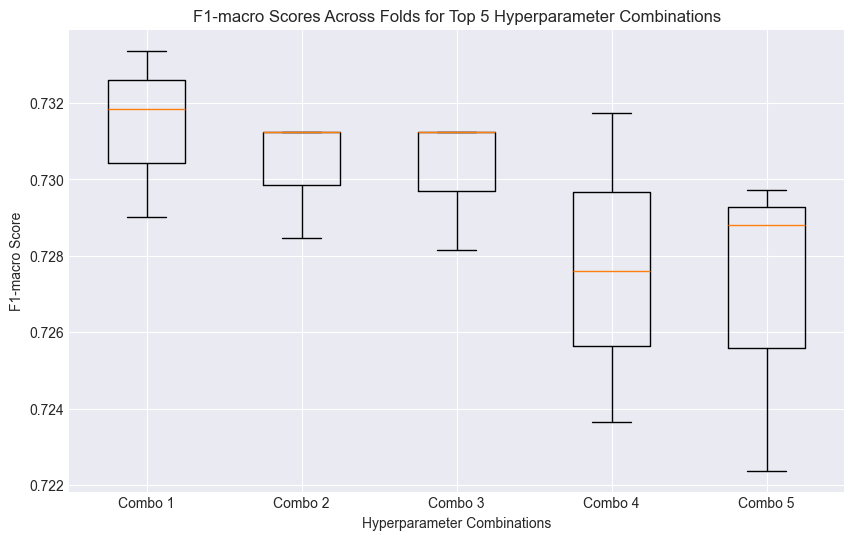

In [5]:
# Top-5 hyperparameter combinations
top5_indices = cvres.sort_values('mean_test_score', ascending=False).index[:5]

# Collect per-fold scores for each of the top-5 configurations
split_cols = sorted(
    [c for c in cvres.columns if c.startswith('split') and c.endswith('_test_score')],
    key=lambda s: int(s.split('_')[0][5:])
)

# Collect scores for the top-5 configurations
top5_scores = [cvres.loc[i, split_cols].to_numpy() for i in top5_indices]

# Boxplot of F1-macro scores across folds for top-5 configurations
plt.figure(figsize=(10, 6))
plt.boxplot(top5_scores, tick_labels=[f'Combo {k+1}' for k in range(len(top5_scores))])
plt.title('F1-macro Scores Across Folds for Top 5 Hyperparameter Combinations')
plt.ylabel('F1-macro Score')
plt.xlabel('Hyperparameter Combinations')
plt.show()

## 3.C Heatmaps: F1 vs pairs of hyperparameters
Visualizes how pairs of hyperparameters affect F1-macro scores using heatmaps.

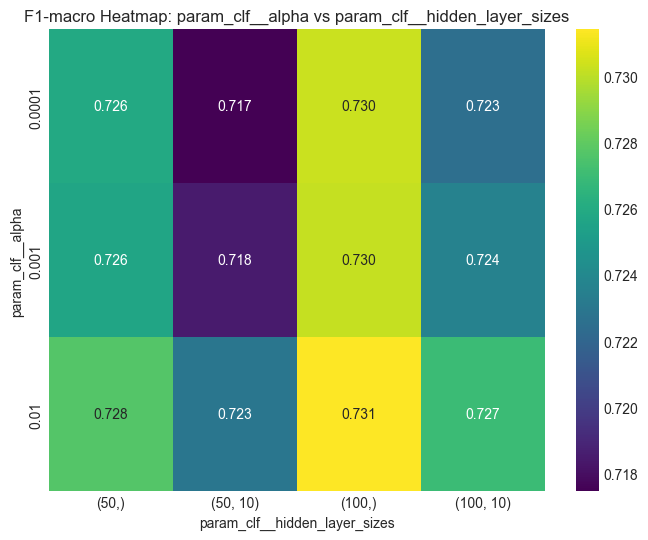

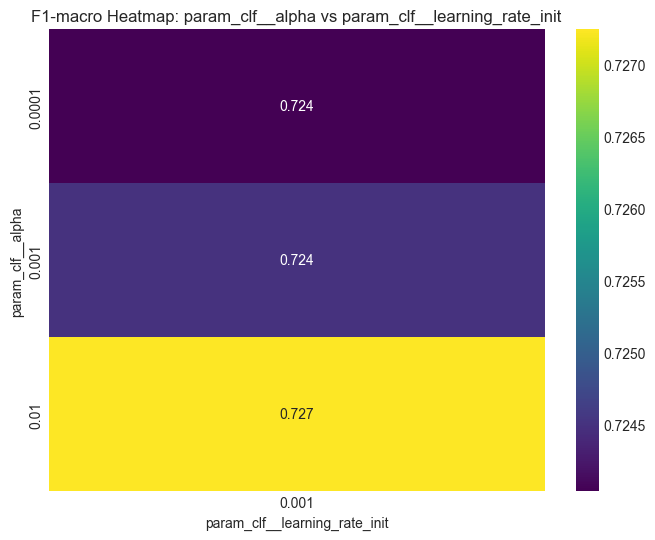

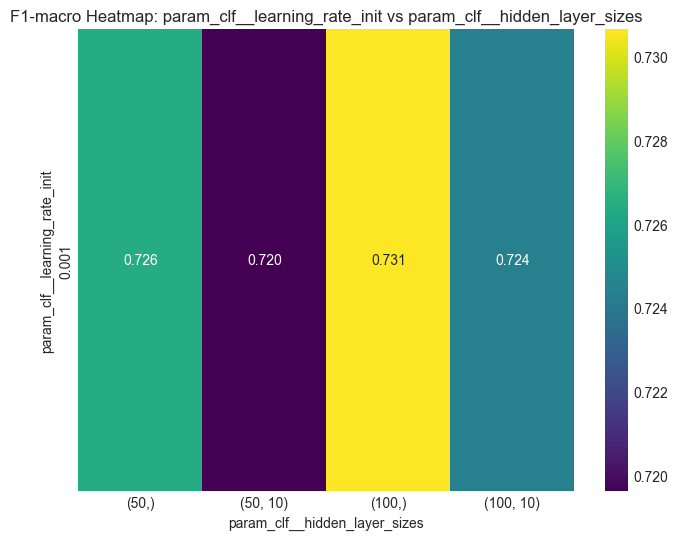

In [6]:
# Best hyperparameters
best_params = grid.best_params_

# Map best_params keys to cv_results_ column names (they use 'param_' prefix)
fixed_params = {
    f'param_{k}': v
    for k, v in best_params.items()
    if k not in ['clf__hidden_layer_sizes', 'clf__alpha']
}

# Function to plot heatmaps for pairs of hyperparameters
def plot_heatmap(cvres, xparam, yparam, fixed: dict):
    # Copy cvres to avoid modifying original
    df = cvres.copy()
    
    # Filter by fixed params
    for k, v in fixed.items():
        df = df[df[k] == v]
    if df.empty:
        print('No rows after filtering with', fixed)
        return

    # Create pivot table
    pivot_table = df.pivot_table(
        values='mean_test_score',
        index=yparam,
        columns=xparam
    )

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    plt.title(f'F1-macro Heatmap: {yparam} vs {xparam}')
    sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap='viridis')
    plt.ylabel(yparam)
    plt.xlabel(xparam)
    plt.show()
    
# Plot heatmaps for pairs of hyperparameters
plot_heatmap(
    cvres,
    'param_clf__hidden_layer_sizes',
    'param_clf__alpha',
    fixed_params
)
plot_heatmap(
    cvres,
    'param_clf__learning_rate_init',
    'param_clf__alpha',
    fixed_params
)
plot_heatmap(
    cvres,
    'param_clf__hidden_layer_sizes',
    'param_clf__learning_rate_init',
    fixed_params
)

## 3.D Short discussion on how the tested hyperparameters affect learning

**Effect of hyperparameters**

The tested hyperparameters show that increasing the number of neurons from 50 to 100 produces a small but consistent improvement in F1-macro, while deeper architectures (e.g., `(50, 10)` or `(100, 10)`) do not show any clear advantage and are sometimes less stable across folds.  
The best configuration, **(100,) with alpha = 0.01 and learning_rate_init = 0.001**, appears in the top region of all heatmaps, confirming that moderate regularization improves generalization.

The heatmaps also show that values of **alpha ≈ 0.01** systematically outperform alpha = 0.0001 or 0.001, especially when combined with larger hidden layers.  
Learning rate variations had a smaller overall effect: with `lr_init = 0.001`, all tested architectures converge stably, while larger learning rates tended to produce slightly more variance.  
Overall, the model benefits primarily from **increased capacity (100 neurons)** and **moderate regularization**, while deeper structures or more aggressive learning rates do not improve results.

In all tested configurations, neither strong underfitting nor overfitting was observed.  
Even the larger architectures (e.g., 100 neurons) did not overfit, which suggests that the dataset is small and regularized enough for the model to remain stable.  
This behaviour indicates that, for this particular task, model capacity is not the main limiting factor: the dataset itself seems to offer limited nonlinear / linear structure for deeper networks to exploit.

## 3.E Short discussion on the best found neural network compared with the SVC

**Comparison with the SVC**

The MLP achieved a best mean F1-macro of **0.7314**, while the SVC previously obtained **0.7356 ± 0.0129**.  
Although the neural network is more flexible and capable of learning non-linear patterns, its performance remains slightly below the simpler SVC.

The boxplots and heatmaps confirm that, while the MLP is stable across folds and hyperparameters, the gains from increasing model complexity are small.  
The dataset appears to be mostly linearly separable, which limits the advantage of deeper or more expressive architectures.  
Because of this, using a neural network for this problem is likely **overkill**: the additional layers, tuning effort, and training time do not translate into meaningful performance improvements over simpler models.

The ROC curve of the SVC (AUC = 0.803) further reinforces its stronger discriminative power.  
The MLP shows stable learning without overfitting, but its extra complexity and computational cost provide no clear benefit for this task when compared to the more efficient SVC.

Given these observations, a more complex neural network is not necessary for this dataset.  
The SVC achieves slightly better predictive performance with far lower computational cost, reinforcing that additional depth or representational power does not bring significant gains for this problem.

## 3.F F1 over epochs for the best hyperparameters
Track **F1‑macro** per epoch on a dedicated **train/test split**. Use `partial_fit` for 200 steps to emulate epochs.

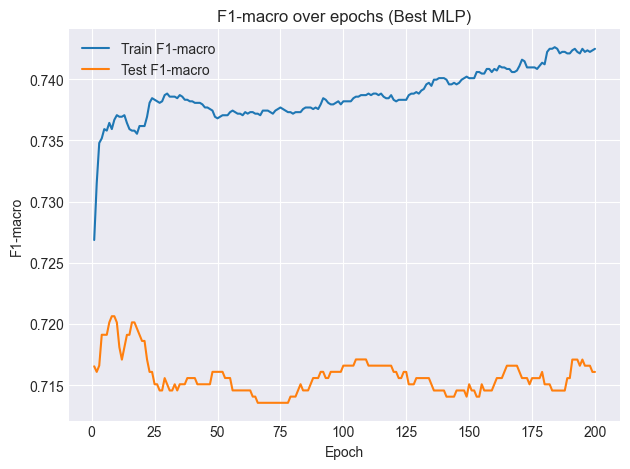

In [7]:
# Hold-out split (train/test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Best hyperparameters from GridSearch
best = MLPClassifier(
    hidden_layer_sizes=best_params['clf__hidden_layer_sizes'],
    activation=best_params['clf__activation'],
    alpha=best_params['clf__alpha'],
    learning_rate_init=best_params['clf__learning_rate_init'],
    solver='adam',
    random_state=42,
    warm_start=True, # Enable warm_start for partial_fit
    max_iter=1, # One epoch per call
)

# Scale data
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Manual training loop (200 epochs)
epochs = 200
classes = np.array([0, 1])
f1_train, f1_test = [], []

for _ in range(epochs):
    best.partial_fit(X_train_s, y_train, classes=classes)
    f1_train.append(f1_score(y_train, best.predict(X_train_s), average='macro'))
    f1_test.append(f1_score(y_test, best.predict(X_test_s), average='macro'))

# Plot F1 evolution
plt.plot(range(1, epochs + 1), f1_train, label='Train F1-macro')
plt.plot(range(1, epochs + 1), f1_test, label='Test F1-macro')
plt.xlabel('Epoch')
plt.ylabel('F1-macro')
plt.title('F1-macro over epochs (Best MLP)')
plt.legend()
plt.tight_layout()
plt.show()

The training F1-macro begins around **0.728** and quickly rises to the **0.735–0.738** range within the first 10 epochs.  
After this initial jump, the curve remains relatively stable, with small oscillations, and gradually increases towards **0.742–0.744** by the end of the 200 epochs.  
This indicates a stable convergence without overfitting, as the training performance does not degrade.

The test F1-macro starts at approximately **0.717**, reaching values close to **0.720–0.721** early in training (around epoch 15–20).  
After this point, the curve flattens and oscillates slightly in the **0.714–0.717** interval for the remainder of the epochs.  
The absence of a downward trend shows that the model does not overfit, even as the training score improves.

The gap between training and test performance remains consistently small (around **0.02–0.025**), indicating good generalization.  
Most of the performance gains happen in the first **20–40 epochs**, with the remaining epochs contributing only marginal improvements.  
Overall, this behaviour confirms that the selected hyperparameters are stable and effective, and that the model reaches convergence well before 200 epochs.

## 4. Bonus: Equivalent model in Keras
The Keras model was configured to match the best hyperparameters found for the scikit-learn MLP:  
`hidden_layer_sizes = (100,)`, `activation = 'logistic'`, `alpha = 0.01`, `learning_rate_init = 0.001`.

Both models were trained for 200 epochs on the same scaled data and evaluated using F1-macro on the training and test sets at each epoch.

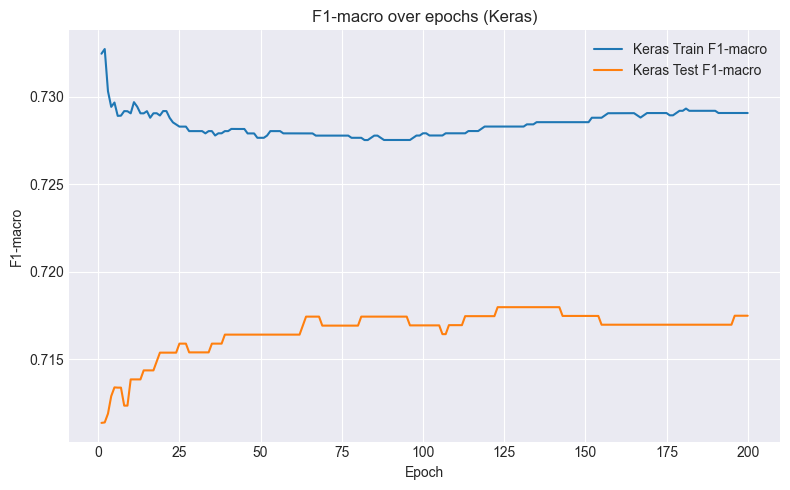

In [8]:
# Extract best params from GridSearchCV
best_act = best_params['clf__activation']
best_act = "sigmoid" if best_act == "logistic" else best_act
best_alpha = best_params['clf__alpha']
best_hls = best_params['clf__hidden_layer_sizes'] # tuple, e.g. (50,)
best_lr = best_params['clf__learning_rate_init']

tf.random.set_seed(42)

# Build Keras model dynamically from scikit-learn best params
model = keras.Sequential()
model.add(layers.Input(shape=(X_train_s.shape[1],)))

# Hidden layers created automatically from best_hls tuple
for units in best_hls:
    model.add(layers.Dense(
        units,
        activation=best_act,
        kernel_regularizer=regularizers.l2(best_alpha)
    ))

# Output layer (binary classification)
model.add(layers.Dense(1, activation='sigmoid'))

# Optimizer with matching learning rate
optimizer = keras.optimizers.Adam(learning_rate=best_lr)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy'
)

epochs = 200
batch_size = 32

f1_train_keras, f1_test_keras = [], []

start = perf_counter()
for epoch in range(epochs):
    # Train exactly 1 epoch
    model.fit(
        X_train_s, y_train,
        epochs=1,
        batch_size=batch_size,
        verbose=0,
        shuffle=True
    )

    # Predict and compute F1
    y_train_pred = (model.predict(X_train_s, verbose=0).ravel() >= 0.5).astype(int)
    y_test_pred  = (model.predict(X_test_s,  verbose=0).ravel() >= 0.5).astype(int)

    f1_train_keras.append(f1_score(y_train, y_train_pred, average='macro'))
    f1_test_keras.append(f1_score(y_test,  y_test_pred,  average='macro'))

end = perf_counter()
train_time_keras = end - start

# Plot evolution of F1
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), f1_train_keras, label='Keras Train F1-macro')
plt.plot(range(1, epochs + 1), f1_test_keras, label='Keras Test F1-macro')
plt.xlabel('Epoch')
plt.ylabel('F1-macro')
plt.title('F1-macro over epochs (Keras)')
plt.legend()
plt.tight_layout()
plt.show()

Mapping scikit-learn’s hyperparameters to Keras revealed that most settings have a direct equivalent  
(e.g., `hidden_layer_sizes -> Dense layers`, `alpha -> L2 regularization`, `learning_rate_init -> optimizer learning rate`).  
The only exception was the `logistic` activation, which in Keras must be specified as `sigmoid`, but all other parameters translated naturally.

## Bonus: Discussion: scikit-learn vs Keras MLP

The Keras model was configured to replicate the best scikit-learn MLP parameters (`100` neurons, `logistic`, `alpha = 0.01`, `lr = 0.001`).  
Both implementations produced comparable F1-macro trends, with the Keras model stabilizing around **0.727–0.730** on the training set and **0.715–0.717** on the test set, matching the behaviour observed in the scikit-learn version.

This behaviour is expected: Keras uses different initialization schemes and small internal variations in the Adam optimizer, producing minor oscillations but no meaningful performance difference.

The final Keras F1-macro on the test set was approximately **0.716–0.717**, consistent with the scikit-learn MLP (mean CV score **0.7314**, and ~0.72 on the hold-out).  
Training on CPU took **79.2 seconds**, with no GPU acceleration available.

As no GPU was available, both implementations ran entirely on CPU.  
This further explains the longer Keras training time, since Keras introduces additional abstraction overhead even when running equivalent computations.

These results confirm that both frameworks achieve nearly identical accuracy and generalization when using the same architecture and hyperparameters.  
For small tabular datasets, the scikit-learn MLP is faster and simpler, while Keras provides greater flexibility for custom architectures, callbacks, and GPU acceleration in larger neural networks.